## Описание исследования
Интернет магазин собирает историю покупателей и планирет будущие продажи. Для оптимизации процессов необходимо выделить покупателей, которые готовы совершить покупку в ближайшие дни.

## Цель исследования
Предсказать вероятность покупки в течение 90 дней

## Задачи исследования
1. Изучить данные
2. Разработать полезные признаки
3. Подобрать модель, используя метрику roc_auc
4. Выполнить тестирование

### Загрузка  библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import phik
import sklearn
import sklearn.metrics as metrics
import lightgbm


from phik import report
from phik.report import plot_correlation_matrix

from sklearn.inspection import permutation_importance 
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold, RandomizedSearchCV

# загружаем классы для подготовки данных
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками 
from sklearn.impute import SimpleImputer

# загружаем класс для работы с несбалансированным дата фреймом
from imblearn.combine import SMOTEENN

from imblearn.pipeline import Pipeline as ImbPipeline

# загружаем нужные модели
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

## Загрузка и подготовка данных

### Данные  по истории рекламных рассылок

In [2]:
# Загрузка файла с историей рекламных рассылок
campaigns = pd.read_csv('/Users/naziaignatenko/Downloads/arkhiv/Masterskaya_2/STD_M2_purchase_in_90_days/filtered_data/apparel-messages.csv')

In [3]:
campaigns.head(10)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52
5,4439,1515915625594606468,1515915625594606468-4439-6283411f277fc,open,email,2022-05-19,2022-05-19 01:04:11
6,4439,1515915625491810918,1515915625491810918-4439-6283411d9d299,open,email,2022-05-19,2022-05-19 01:19:54
7,4439,1515915625474219766,1515915625474219766-4439-628341212233a,open,email,2022-05-19,2022-05-19 01:23:43
8,4439,1515915625474219766,1515915625474219766-4439-628341212233a,click,email,2022-05-19,2022-05-19 01:24:16
9,4439,1515915625566741491,1515915625566741491-4439-6283412871599,open,email,2022-05-19,2022-05-19 01:31:06


#### Изучим загруженный дата фрейм по истории рассылок

In [4]:
campaigns.shape

(12739798, 7)

In [5]:
campaigns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


Из шести столбцов только два содержат данные типа int, остальные 4 содержат данные типа object

In [6]:
campaigns.describe()

,bulk_campaign_id,client_id
count,1.273980e+07,1.273980e+07
mean,1.160459e+04,1.515916e+18
std,3.259211e+03,3.265518e+08
min,5.480000e+02,1.515916e+18
25%,8.746000e+03,1.515916e+18
50%,1.351600e+04,1.515916e+18
75%,1.415800e+04,1.515916e+18
max,1.465700e+04,1.515916e+18


In [7]:
campaigns.describe(include = 'object')

,message_id,event,channel,date,created_at
count,12739798,12739798,12739798,12739798,12739798
unique,9061667,11,2,638,4103539
top,1515915625489095763-6251-6311b13a4cf78,send,mobile_push,2023-06-10,2023-12-29 15:20:53
freq,1454,9058196,7512156,89661,621


In [8]:
# Определим количество дубликатов
campaigns.duplicated().sum()

48610

In [9]:
# Удалим явные дубликаты
campaigns = campaigns.drop_duplicates()

In [10]:
# Check
campaigns.duplicated().sum()

0

In [11]:
# Определим количество индикаторов рекламных кампаний
len(campaigns['bulk_campaign_id'].unique())

2709

In [12]:
# Посмотрим на уникальные значения колонки event
campaigns['event'].unique()

array(['open', 'click', 'purchase', 'send', 'unsubscribe', 'hbq_spam',
       'hard_bounce', 'subscribe', 'soft_bounce', 'complain', 'close'],
      dtype=object)

In [13]:
# Развернем колонку 'event' и для каждого клиента посчитаем количество каждого уникального события
campaigns_event = campaigns.pivot_table(index = 'client_id', columns = 'event', aggfunc = 'size')
campaigns_event.head()

event,click,close,complain,hard_bounce,hbq_spam,open,purchase,send,soft_bounce,subscribe,unsubscribe
client_id,,,,,,,,,,,
1515915625468060902,10.0,NaN,NaN,NaN,NaN,35.0,5.0,126.0,NaN,NaN,1.0
1515915625468061003,5.0,NaN,NaN,NaN,NaN,5.0,1.0,154.0,NaN,NaN,NaN
1515915625468061099,8.0,NaN,NaN,2.0,NaN,51.0,NaN,215.0,NaN,NaN,NaN
1515915625468061100,1.0,NaN,NaN,1.0,NaN,157.0,1.0,267.0,1.0,NaN,NaN
1515915625468061170,16.0,NaN,NaN,NaN,NaN,31.0,3.0,243.0,NaN,NaN,NaN


In [14]:
# Изучим полученную таблицу
campaigns_event.describe()

event,click,close,complain,hard_bounce,hbq_spam,open,purchase,send,soft_bounce,subscribe,unsubscribe
count,48060.000000,1.0,281.000000,12752.000000,806.000000,44710.000000,42055.000000,53303.000000,1882.000000,75.000000,2209.000000
mean,10.056721,1.0,1.875445,1.549796,1.021092,68.272892,1.488360,169.937414,5.622742,1.133333,1.282481
std,14.583228,NaN,5.720465,1.358215,0.143780,76.232407,1.415155,113.823664,14.349109,0.413728,0.668837
min,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.0,1.000000,1.000000,1.000000,8.000000,1.000000,88.000000,1.000000,1.000000,1.000000
50%,6.000000,1.0,1.000000,1.000000,1.000000,36.000000,1.000000,160.000000,1.000000,1.000000,1.000000
75%,12.000000,1.0,1.000000,2.000000,1.000000,108.000000,2.000000,251.000000,2.000000,1.000000,1.000000
max,1300.000000,1.0,80.000000,36.000000,2.000000,1268.000000,117.000000,2473.000000,141.000000,3.000000,8.000000


Из полученных колонок можно оставить 3 наиболее значимые с точки зрения покупок, а остальные объединить

In [15]:
campaigns_event_retained = campaigns_event[['open', 'purchase']]
campaigns_event['others'] = campaigns_event.drop(columns = ['open', 'purchase']).sum(axis = 1)
campaigns_event_resulted = campaigns_event_retained.join(campaigns_event['others'])
campaigns_event_resulted.head()

,open,purchase,others
client_id,,,
1515915625468060902,35.0,5.0,137.0
1515915625468061003,5.0,1.0,159.0
1515915625468061099,51.0,NaN,225.0
1515915625468061100,157.0,1.0,270.0
1515915625468061170,31.0,3.0,259.0


In [16]:
# Развернем колонку 'channel' и для каждого клиента посчитаем количество сообщений, принятых по разным каналам
campaigns_channel = campaigns.pivot_table(index = 'client_id', columns = 'channel', aggfunc = 'size')
campaigns_channel.head()

channel,email,mobile_push
client_id,,
1515915625468060902,177.0,NaN
1515915625468061003,165.0,NaN
1515915625468061099,182.0,94.0
1515915625468061100,NaN,428.0
1515915625468061170,202.0,91.0


In [17]:
# Преобразуем данные в колонке date_message в тип datetime
campaigns['date_message'] = pd.to_datetime(campaigns['date'])

In [18]:
# Создадим дата фрейм по каждому клиенту с количеством отправленных ему сообщений и 
# количеством уникальных дат сообщений

campaigns_df = campaigns.groupby('client_id').agg(
    cnt_client_id = ('client_id', 'count'),
    cnt_msg_dates = ('date', lambda x: len(set(x))),
    first_msg_date = ('date_message', 'min'),
    last_msg_date = ('date_message', 'max')
    )
campaigns_df.head()

,cnt_client_id,cnt_msg_dates,first_msg_date,last_msg_date
client_id,,,,
1515915625468060902,177,136,2022-05-19,2024-01-19
1515915625468061003,165,155,2022-05-20,2024-02-13
1515915625468061099,276,191,2022-05-19,2024-02-13
1515915625468061100,428,228,2022-05-19,2024-02-15
1515915625468061170,293,212,2022-05-25,2024-02-15


#### Из полученных данных видно, что в один день клиент может получить несколько разных сообщений

In [19]:
# Объединим три полученные таблицы
campaigns_conc = pd.concat([campaigns_event_resulted, campaigns_channel, campaigns_df], axis = 1)
campaigns_conc.head()

,open,purchase,others,email,mobile_push,cnt_client_id,cnt_msg_dates,first_msg_date,last_msg_date
client_id,,,,,,,,,
1515915625468060902,35.0,5.0,137.0,177.0,NaN,177,136,2022-05-19,2024-01-19
1515915625468061003,5.0,1.0,159.0,165.0,NaN,165,155,2022-05-20,2024-02-13
1515915625468061099,51.0,NaN,225.0,182.0,94.0,276,191,2022-05-19,2024-02-13
1515915625468061100,157.0,1.0,270.0,NaN,428.0,428,228,2022-05-19,2024-02-15
1515915625468061170,31.0,3.0,259.0,202.0,91.0,293,212,2022-05-25,2024-02-15


In [20]:
# Для каждого клиента вычислим длительность получения сообщений и частоту их получения
campaigns_conc['msg_duration'] = (campaigns_conc['last_msg_date'] - campaigns_conc['first_msg_date']).dt.days
campaigns_conc['msg_freq'] = campaigns_conc['cnt_client_id']/campaigns_conc['msg_duration']
campaigns_conc.head()

,open,purchase,others,email,mobile_push,cnt_client_id,cnt_msg_dates,first_msg_date,last_msg_date,msg_duration,msg_freq
client_id,,,,,,,,,,,
1515915625468060902,35.0,5.0,137.0,177.0,NaN,177,136,2022-05-19,2024-01-19,610,0.290164
1515915625468061003,5.0,1.0,159.0,165.0,NaN,165,155,2022-05-20,2024-02-13,634,0.260252
1515915625468061099,51.0,NaN,225.0,182.0,94.0,276,191,2022-05-19,2024-02-13,635,0.434646
1515915625468061100,157.0,1.0,270.0,NaN,428.0,428,228,2022-05-19,2024-02-15,637,0.671900
1515915625468061170,31.0,3.0,259.0,202.0,91.0,293,212,2022-05-25,2024-02-15,631,0.464342


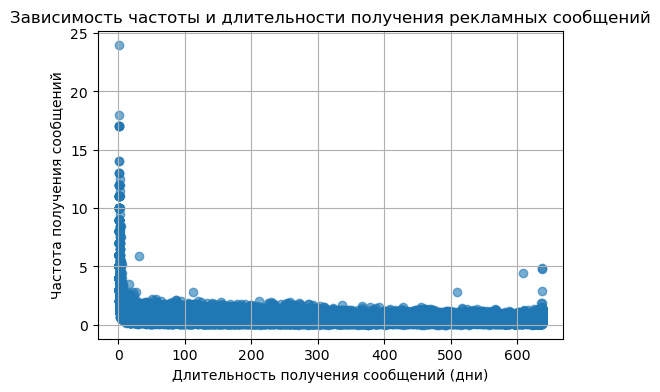

In [21]:
plt.figure(figsize = (6,4))
plt.scatter(campaigns_conc['msg_duration'], campaigns_conc['msg_freq'], alpha = 0.6)
plt.title('Зависимость частоты и длительности получения рекламных сообщений')
plt.xlabel('Длительность получения сообщений (дни)')
plt.ylabel('Частота получения сообщений')
plt.grid()

plt.show()

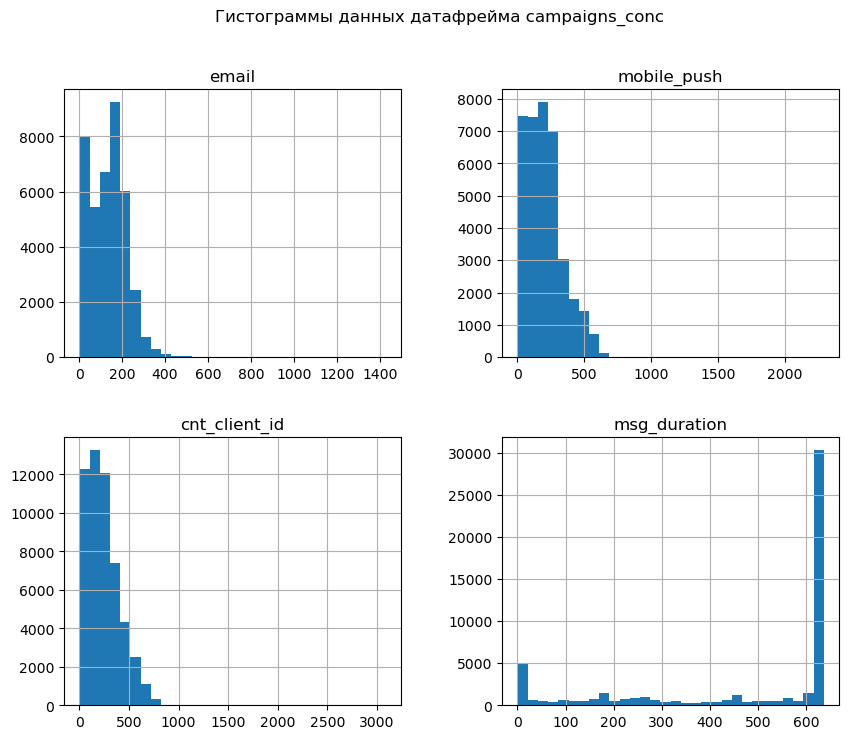

In [22]:
df_cmp_hist = campaigns_conc[['email', 'mobile_push', 'cnt_client_id', 'msg_duration']]
df_cmp_hist.hist(bins = 30, figsize = (10, 8), layout = (2, 2))
plt.suptitle('Гистограммы данных датафрейма campaigns_conc')
plt.show()

Из гистограммы длительности получения сообщений видно, что они рассылались неравномерно 

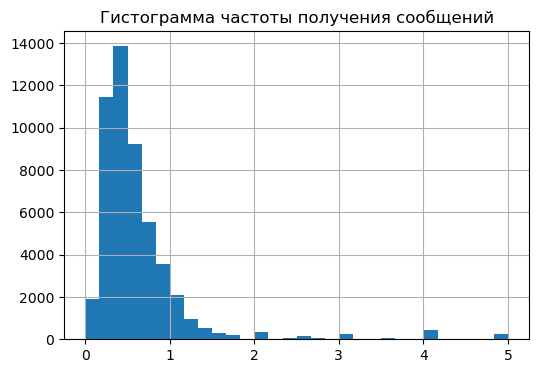

In [23]:
campaigns_conc['msg_freq'].hist(bins = 30, figsize = (6, 4), range = (0, 5))
plt.title('Гистограмма частоты получения сообщений')
plt.show();

### Данные  по истории покупок

In [24]:
# Загрузка файла с историей покупок
clients = pd.read_csv('/Users/naziaignatenko/Downloads/arkhiv/Masterskaya_2/STD_M2_purchase_in_90_days/filtered_data/apparel-purchases.csv')

In [25]:
clients.head()

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


#### Изучим загруженный дата фрейм по истории покупок

In [26]:
clients.shape

(202208, 6)

In [27]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


В полученном дата фрейме три колонки с данными object и три с количественными данными, две из которых содержат данные типа int64 и одна - float64

In [28]:
clients.describe()

,client_id,quantity,price
count,2.022080e+05,202208.000000,202208.000000
mean,1.515916e+18,1.006483,1193.301516
std,1.459514e+08,0.184384,1342.252664
min,1.515916e+18,1.000000,1.000000
25%,1.515916e+18,1.000000,352.000000
50%,1.515916e+18,1.000000,987.000000
75%,1.515916e+18,1.000000,1699.000000
max,1.515916e+18,30.000000,85499.000000


In [29]:
clients.describe(include = 'object')

,category_ids,date,message_id
count,202208,202208,202208
unique,933,642,50204
top,"['4', '28', '57', '431']",2022-11-11,1515915625489095763-6251-6311b13a4cf78
freq,8626,5270,365


In [30]:
# Определим количество дубликатов
clients.duplicated().sum()

73020

In [31]:
# Удалим явные дубликаты
clients = clients.drop_duplicates()

In [32]:
# check
clients.duplicated().sum()

0

В колонке category_ids код товара зашифрован 4 цифрами. Разделим 4 цифры и посмотрим частоту встречаемости для каждого клиента.

In [33]:
# Функция преобразования зеачений в список и создать 4 колонки, заполнив 0 отсутствующие значения
def convert_to_list(val):
    # Проверка, является ли значение NaN, если оно не является списком или массивом 
    if isinstance(val, (float, int)) and pd.isna(val):
        return [np.nan] * 4  # Возвращение списка для 4 NaN
    elif isinstance(val, str):  # Проверка, является ли значение строкой
        try:
            list_val = eval(val)  # Преобразование строки в список
            # Проверка, дествительно ли список содержит 4 элемента
            return list_val[:4] + [np.nan] * (4 - len(list_val))  
        except:
            return [np.nan] * 4
    elif isinstance(val, (list, np.ndarray)):  # Прверка, существует ли уже значение в списке или массиве
        return val[:4] + [np.nan] * (4 - len(val))  # Проверка, что список содержит 4 элемента 
    else:
        return [np.nan] * 4  # Возвращаем список из NaN 

# Применяем функцию к колонке 'category_ids' 
clients['category_ids'] = clients['category_ids'].apply(convert_to_list)

# Расширяем список на отдельные колонки
clients[['category_1', 'category_2', 'category_3', 'category_4']] = pd.DataFrame(
    clients['category_ids'].tolist(), index=clients.index)

# Преобразуем данные в int
clients[['category_1', 'category_2', 'category_3', 'category_4']] = clients[
    ['category_1', 'category_2', 'category_3', 'category_4']
].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)

# Отображаем полученный дата фрейм
clients.head()

,client_id,quantity,price,category_ids,date,message_id,category_1,category_2,category_3,category_4
0,1515915625468169594,1,1999.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,4,28,57,431
1,1515915625468169594,1,2499.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,4,28,57,431
2,1515915625471138230,1,6499.0,"[4, 28, 57, 431]",2022-05-16,1515915625471138230-4437-6282242f27843,4,28,57,431
3,1515915625471138230,1,4999.0,"[4, 28, 244, 432]",2022-05-16,1515915625471138230-4437-6282242f27843,4,28,244,432
4,1515915625471138230,1,4999.0,"[4, 28, 49, 413]",2022-05-16,1515915625471138230-4437-6282242f27843,4,28,49,413


In [34]:
clients.describe()

,client_id,quantity,price,category_1,category_2,category_3,category_4
count,1.291880e+05,129188.000000,129188.000000,129188.000000,129188.000000,129188.000000,129188.000000
mean,1.515916e+18,1.009420,1264.532766,1503.012594,1590.442727,1737.924993,875.127427
std,1.452558e+08,0.220332,1375.016339,2491.047010,2505.832499,2446.268124,1041.499742
min,1.515916e+18,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1.515916e+18,1.000000,399.000000,4.000000,28.000000,171.000000,432.000000
50%,1.515916e+18,1.000000,999.000000,4.000000,28.000000,274.000000,551.000000
75%,1.515916e+18,1.000000,1750.000000,5562.000000,5536.000000,5549.000000,726.000000
max,1.515916e+18,30.000000,85499.000000,6060.000000,6059.000000,6309.000000,6323.000000


Выведем уникальные значения в 4 полученных столбцах

In [35]:
clients['category_1'].unique()

array([   4,    2, 5562,    1,    0, 5963,    3, 6060,    5])

In [36]:
clients['category_2'].unique()

array([  28,   18, 5631, 5630,   27, 5589, 5634,   31, 1822, 5837,   17,
       5683,   29, 5536, 5597, 5633, 5599, 5632, 5558,   30,    8, 5697,
          0,   22, 5959,   14,   44, 6058, 6059, 6057,   10,   12])

In [37]:
len(clients['category_3'].unique())

292

In [38]:
len(clients['category_4'].unique())

839

Посмотрим как они распределены

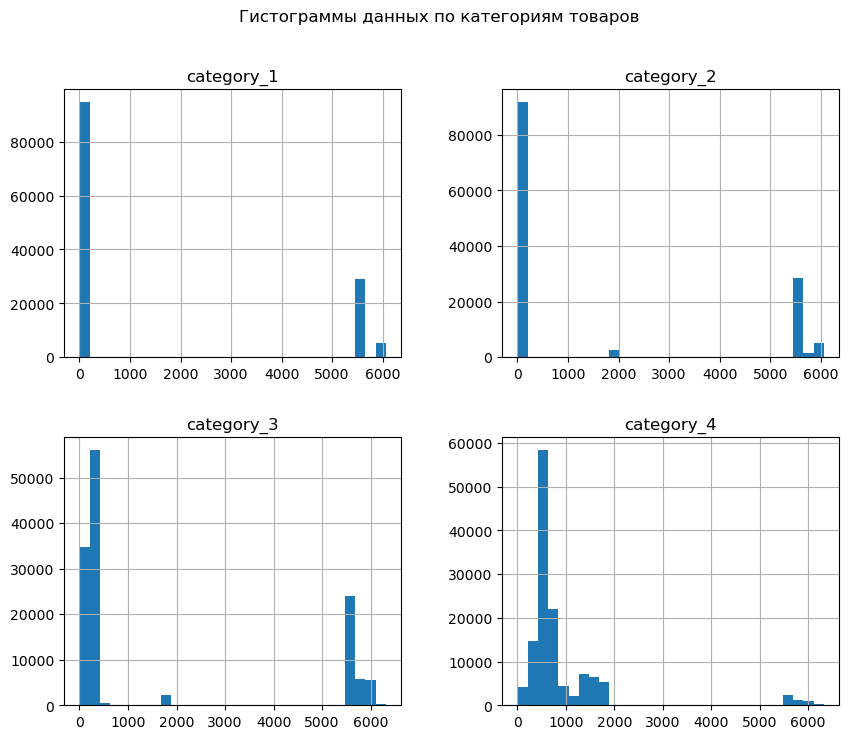

In [39]:
df_clnt = clients[['category_1', 'category_2', 'category_3', 'category_4']]
df_clnt.hist(bins = 30, figsize = (10, 8), layout = (2, 2))
plt.suptitle('Гистограммы данных по категориям товаров')
plt.show()

In [40]:
# Преобразуем данные колонки date в тип datetime
clients['date_message'] = pd.to_datetime(campaigns['date'])

In [41]:
# Создадим дата фрейм по каждому клиенту с количеством купленных товаров, средней ценой покупки,  
# количеством покупок и количеством дат покупок
clients_df = clients.groupby('client_id').agg(
    cnt_client_prch = ('client_id', 'count'),
    cnt_cat_1 = ('category_1', lambda x: len(set(x))),
    cnt_cat_2 = ('category_2', lambda x: len(set(x))),
    cnt_cat_3 = ('category_3', lambda x: len(set(x))),
    cnt_cat_4 = ('category_4', lambda x: len(set(x))),
    cnt_total_cat = ('category_ids', lambda x: len(x)),
    mean_price = ('price', lambda x: np.mean(
        [item for sublist in x for item in sublist] if isinstance(x.iloc[0], list) else x)),
    total_price = ('price', 'sum'),
    purchases_nmb = ('category_ids', lambda x: len(
        set([item for sublist in x for item in sublist] if isinstance(x.iloc[0], list) else x))),
    dates_prch_nmb = ('date', lambda x: len(set(x))),
    first_prch_date = ('date', 'min'),
    last_prch_date = ('date', 'max')
)

clients_df.head()

,cnt_client_prch,cnt_cat_1,cnt_cat_2,cnt_cat_3,cnt_cat_4,cnt_total_cat,mean_price,total_price,purchases_nmb,dates_prch_nmb,first_prch_date,last_prch_date
client_id,,,,,,,,,,,,
1515915625468060902,5,1,2,5,5,5,959.000000,4795.0,13,1,2022-05-27,2022-05-27
1515915625468061003,6,1,1,1,1,6,2355.833333,14135.0,4,1,2023-01-04,2023-01-04
1515915625468061099,1,1,1,1,1,1,299.000000,299.0,4,1,2022-05-17,2022-05-17
1515915625468061100,1,1,1,1,1,1,1049.000000,1049.0,4,1,2024-02-10,2024-02-10
1515915625468061170,8,3,3,4,4,8,1762.750000,14102.0,11,3,2023-03-26,2023-06-17


In [42]:
# Создадим новые колонки длительность покупок и частота покупок
clients_df['last_prch_date'] = pd.to_datetime(clients_df['last_prch_date'])
clients_df['first_prch_date'] = pd.to_datetime(clients_df['first_prch_date'])

# Now calculate the duration
clients_df['prch_duration'] = (clients_df['last_prch_date'] - clients_df['first_prch_date']).dt.days

# Calculate the frequency, avoiding division by zero
clients_df['prch_freq'] = clients_df.apply(
    lambda row: row['cnt_client_prch'] / row['prch_duration'] if row['prch_duration'] > 0 else 0,
    axis=1
)

clients_df.head()

,cnt_client_prch,cnt_cat_1,cnt_cat_2,cnt_cat_3,cnt_cat_4,cnt_total_cat,mean_price,total_price,purchases_nmb,dates_prch_nmb,first_prch_date,last_prch_date,prch_duration,prch_freq
client_id,,,,,,,,,,,,,,
1515915625468060902,5,1,2,5,5,5,959.000000,4795.0,13,1,2022-05-27,2022-05-27,0,0.000000
1515915625468061003,6,1,1,1,1,6,2355.833333,14135.0,4,1,2023-01-04,2023-01-04,0,0.000000
1515915625468061099,1,1,1,1,1,1,299.000000,299.0,4,1,2022-05-17,2022-05-17,0,0.000000
1515915625468061100,1,1,1,1,1,1,1049.000000,1049.0,4,1,2024-02-10,2024-02-10,0,0.000000
1515915625468061170,8,3,3,4,4,8,1762.750000,14102.0,11,3,2023-03-26,2023-06-17,83,0.096386


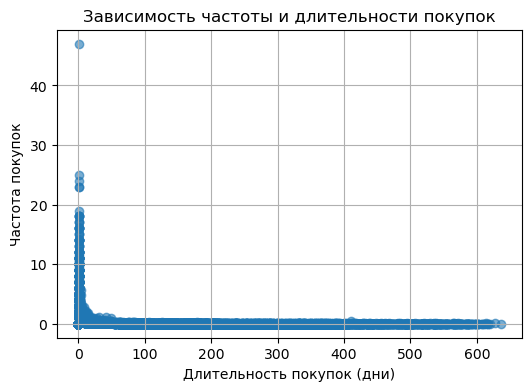

In [43]:
# Прсмотрим как распределена частота от длительности покупок
plt.figure(figsize = (6,4))
plt.scatter(clients_df['prch_duration'], clients_df['prch_freq'], alpha = 0.6)
plt.title('Зависимость частоты и длительности покупок')
plt.xlabel('Длительность покупок (дни)')
plt.ylabel('Частота покупок')
plt.grid()

plt.show()

Видно, что большинство покупок клиентов приходятся на ближайшие дни

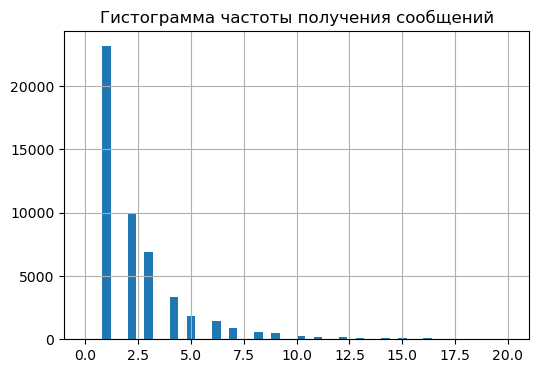

In [44]:
# Посмотрим как распределено количество покупок
clients_df['cnt_client_prch'].hist(bins = 50, figsize = (6, 4), range = (0, 20))
plt.title('Гистограмма частоты получения сообщений')
plt.show()

In [45]:
m = clients_df[clients_df['cnt_client_prch']>10]['cnt_client_prch'].count()/clients_df.shape[0]
print(m)

0.020842945696001924


Очень мало клиентов, совершивших более 10 покупок

In [46]:
clients_df['90_days'] = clients_df.apply(
    lambda x: 1 if (x['cnt_client_prch'] !=0 and x['prch_duration'] <=90) else 0, axis = 1)
clients_df.head()

,cnt_client_prch,cnt_cat_1,cnt_cat_2,cnt_cat_3,cnt_cat_4,cnt_total_cat,mean_price,total_price,purchases_nmb,dates_prch_nmb,first_prch_date,last_prch_date,prch_duration,prch_freq,90_days
client_id,,,,,,,,,,,,,,,
1515915625468060902,5,1,2,5,5,5,959.000000,4795.0,13,1,2022-05-27,2022-05-27,0,0.000000,1
1515915625468061003,6,1,1,1,1,6,2355.833333,14135.0,4,1,2023-01-04,2023-01-04,0,0.000000,1
1515915625468061099,1,1,1,1,1,1,299.000000,299.0,4,1,2022-05-17,2022-05-17,0,0.000000,1
1515915625468061100,1,1,1,1,1,1,1049.000000,1049.0,4,1,2024-02-10,2024-02-10,0,0.000000,1
1515915625468061170,8,3,3,4,4,8,1762.750000,14102.0,11,3,2023-03-26,2023-06-17,83,0.096386,1


In [47]:
# Создадим колонку отрезка времени между самой последней покупкой и последней покупкой по каждому клиенту
max_prch_date = clients_df['last_prch_date'].max()
# Now calculate the duration
clients_df['last_prch_duration'] = (max_prch_date - clients_df['first_prch_date']).dt.days

clients_df.head()

,cnt_client_prch,cnt_cat_1,cnt_cat_2,cnt_cat_3,cnt_cat_4,cnt_total_cat,mean_price,total_price,purchases_nmb,dates_prch_nmb,first_prch_date,last_prch_date,prch_duration,prch_freq,90_days,last_prch_duration
client_id,,,,,,,,,,,,,,,,
1515915625468060902,5,1,2,5,5,5,959.000000,4795.0,13,1,2022-05-27,2022-05-27,0,0.000000,1,630
1515915625468061003,6,1,1,1,1,6,2355.833333,14135.0,4,1,2023-01-04,2023-01-04,0,0.000000,1,408
1515915625468061099,1,1,1,1,1,1,299.000000,299.0,4,1,2022-05-17,2022-05-17,0,0.000000,1,640
1515915625468061100,1,1,1,1,1,1,1049.000000,1049.0,4,1,2024-02-10,2024-02-10,0,0.000000,1,6
1515915625468061170,8,3,3,4,4,8,1762.750000,14102.0,11,3,2023-03-26,2023-06-17,83,0.096386,1,327


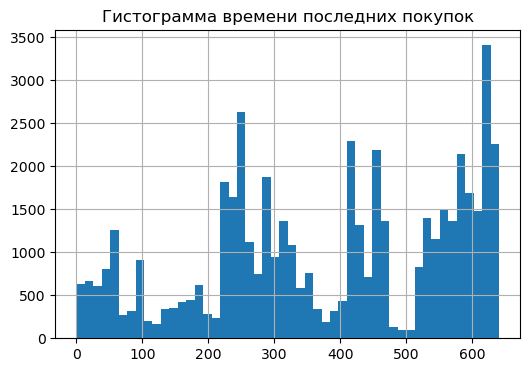

In [48]:
# Посмотрим как распределен этот промежуток времени
clients_df['last_prch_duration'].hist(bins = 50, figsize = (6, 4))
plt.title('Гистограмма времени последних покупок')
plt.show()

Видна неравномерность в распределении. Видно несколько пиков.

In [49]:
# Объединим полученные дата фреймы
merged_df = clients_df.merge(campaigns_conc, on = 'client_id', how = 'left')
merged_df.head()

,cnt_client_prch,cnt_cat_1,cnt_cat_2,cnt_cat_3,cnt_cat_4,cnt_total_cat,mean_price,total_price,purchases_nmb,dates_prch_nmb,...,purchase,others,email,mobile_push,cnt_client_id,cnt_msg_dates,first_msg_date,last_msg_date,msg_duration,msg_freq
client_id,,,,,,,,,,,,,,,,,,,,,
1515915625468060902,5,1,2,5,5,5,959.000000,4795.0,13,1,...,5.0,137.0,177.0,NaN,177.0,136.0,2022-05-19,2024-01-19,610.0,0.290164
1515915625468061003,6,1,1,1,1,6,2355.833333,14135.0,4,1,...,1.0,159.0,165.0,NaN,165.0,155.0,2022-05-20,2024-02-13,634.0,0.260252
1515915625468061099,1,1,1,1,1,1,299.000000,299.0,4,1,...,NaN,225.0,182.0,94.0,276.0,191.0,2022-05-19,2024-02-13,635.0,0.434646
1515915625468061100,1,1,1,1,1,1,1049.000000,1049.0,4,1,...,1.0,270.0,NaN,428.0,428.0,228.0,2022-05-19,2024-02-15,637.0,0.671900
1515915625468061170,8,3,3,4,4,8,1762.750000,14102.0,11,3,...,3.0,259.0,202.0,91.0,293.0,212.0,2022-05-25,2024-02-15,631.0,0.464342


In [50]:
merged_df.shape

(49849, 27)

### Данные  с целевым признаком

In [51]:
# Загрузка файла с целевым признаком
targets = pd.read_csv(
    '/Users/naziaignatenko/Downloads/arkhiv/Masterskaya_2/STD_M2_purchase_in_90_days/filtered_data/apparel-target_binary.csv')

In [52]:
targets.head()

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


#### Изучим загруженный дата фрейм 

In [53]:
targets.shape

(49849, 2)

In [54]:
targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


In [55]:
# Определим количество дубликатов
targets.duplicated().sum()

0

In [56]:
targets.groupby('target')['target'].value_counts()

target
0    48888
1      961
Name: count, dtype: int64

In [57]:
961/48888*100

1.9657175585010636

Данные сильно несбалансированы, количество клиентов, совершивших покупку, существенно ниже тех, кто ничего не купил. Доля клиентов с покупками составляет всего примерно 2%.

In [58]:
# Объединим полученный выше объединенный дата фрейм с дата фреймом с целевым признаком
final_df = pd.merge(targets, merged_df, on = 'client_id', how = 'inner')
final_df.head()

,client_id,target,cnt_client_prch,cnt_cat_1,cnt_cat_2,cnt_cat_3,cnt_cat_4,cnt_total_cat,mean_price,total_price,...,purchase,others,email,mobile_push,cnt_client_id,cnt_msg_dates,first_msg_date,last_msg_date,msg_duration,msg_freq
0,1515915625468060902,0,5,1,2,5,5,5,959.000000,4795.0,...,5.0,137.0,177.0,NaN,177.0,136.0,2022-05-19,2024-01-19,610.0,0.290164
1,1515915625468061003,1,6,1,1,1,1,6,2355.833333,14135.0,...,1.0,159.0,165.0,NaN,165.0,155.0,2022-05-20,2024-02-13,634.0,0.260252
2,1515915625468061099,0,1,1,1,1,1,1,299.000000,299.0,...,NaN,225.0,182.0,94.0,276.0,191.0,2022-05-19,2024-02-13,635.0,0.434646
3,1515915625468061100,0,1,1,1,1,1,1,1049.000000,1049.0,...,1.0,270.0,NaN,428.0,428.0,228.0,2022-05-19,2024-02-15,637.0,0.671900
4,1515915625468061170,0,8,3,3,4,4,8,1762.750000,14102.0,...,3.0,259.0,202.0,91.0,293.0,212.0,2022-05-25,2024-02-15,631.0,0.464342


In [59]:
final_df.shape

(49849, 29)

In [60]:
final_df.columns

Index(['client_id', 'target', 'cnt_client_prch', 'cnt_cat_1', 'cnt_cat_2',
       'cnt_cat_3', 'cnt_cat_4', 'cnt_total_cat', 'mean_price', 'total_price',
       'purchases_nmb', 'dates_prch_nmb', 'first_prch_date', 'last_prch_date',
       'prch_duration', 'prch_freq', '90_days', 'last_prch_duration', 'open',
       'purchase', 'others', 'email', 'mobile_push', 'cnt_client_id',
       'cnt_msg_dates', 'first_msg_date', 'last_msg_date', 'msg_duration',
       'msg_freq'],
      dtype='object')

### Посмотрим на корреляцию признаков

In [61]:
# Создадим новый датафрейм, из которого удалим колонки с датами
assessed_df = final_df[['client_id', 'target', 'cnt_client_prch', 'cnt_cat_1', 'cnt_cat_2',
       'cnt_cat_3', 'cnt_cat_4', 'cnt_total_cat', 'mean_price', 'total_price',
       'purchases_nmb', 'dates_prch_nmb',
       'prch_duration', 'prch_freq', '90_days', 'last_prch_duration', 'open',
       'purchase', 'others', 'email', 'mobile_push', 'cnt_client_id',
       'cnt_msg_dates', 'msg_duration']]

In [62]:
assessed_df_phik = assessed_df.drop(['client_id'], axis = 1)
phik_overview = assessed_df_phik.phik_matrix(interval_cols = ['target', 'cnt_client_prch', 'cnt_cat_1', 'cnt_cat_2',
       'cnt_cat_3', 'cnt_cat_4', 'cnt_total_cat', 'mean_price', 'total_price',
       'purchases_nmb', 'dates_prch_nmb',
       'prch_duration', 'prch_freq', '90_days', 'last_prch_duration', 'open',
       'purchase', 'others', 'email', 'mobile_push', 'cnt_client_id',
       'cnt_msg_dates', 'msg_duration'])
       

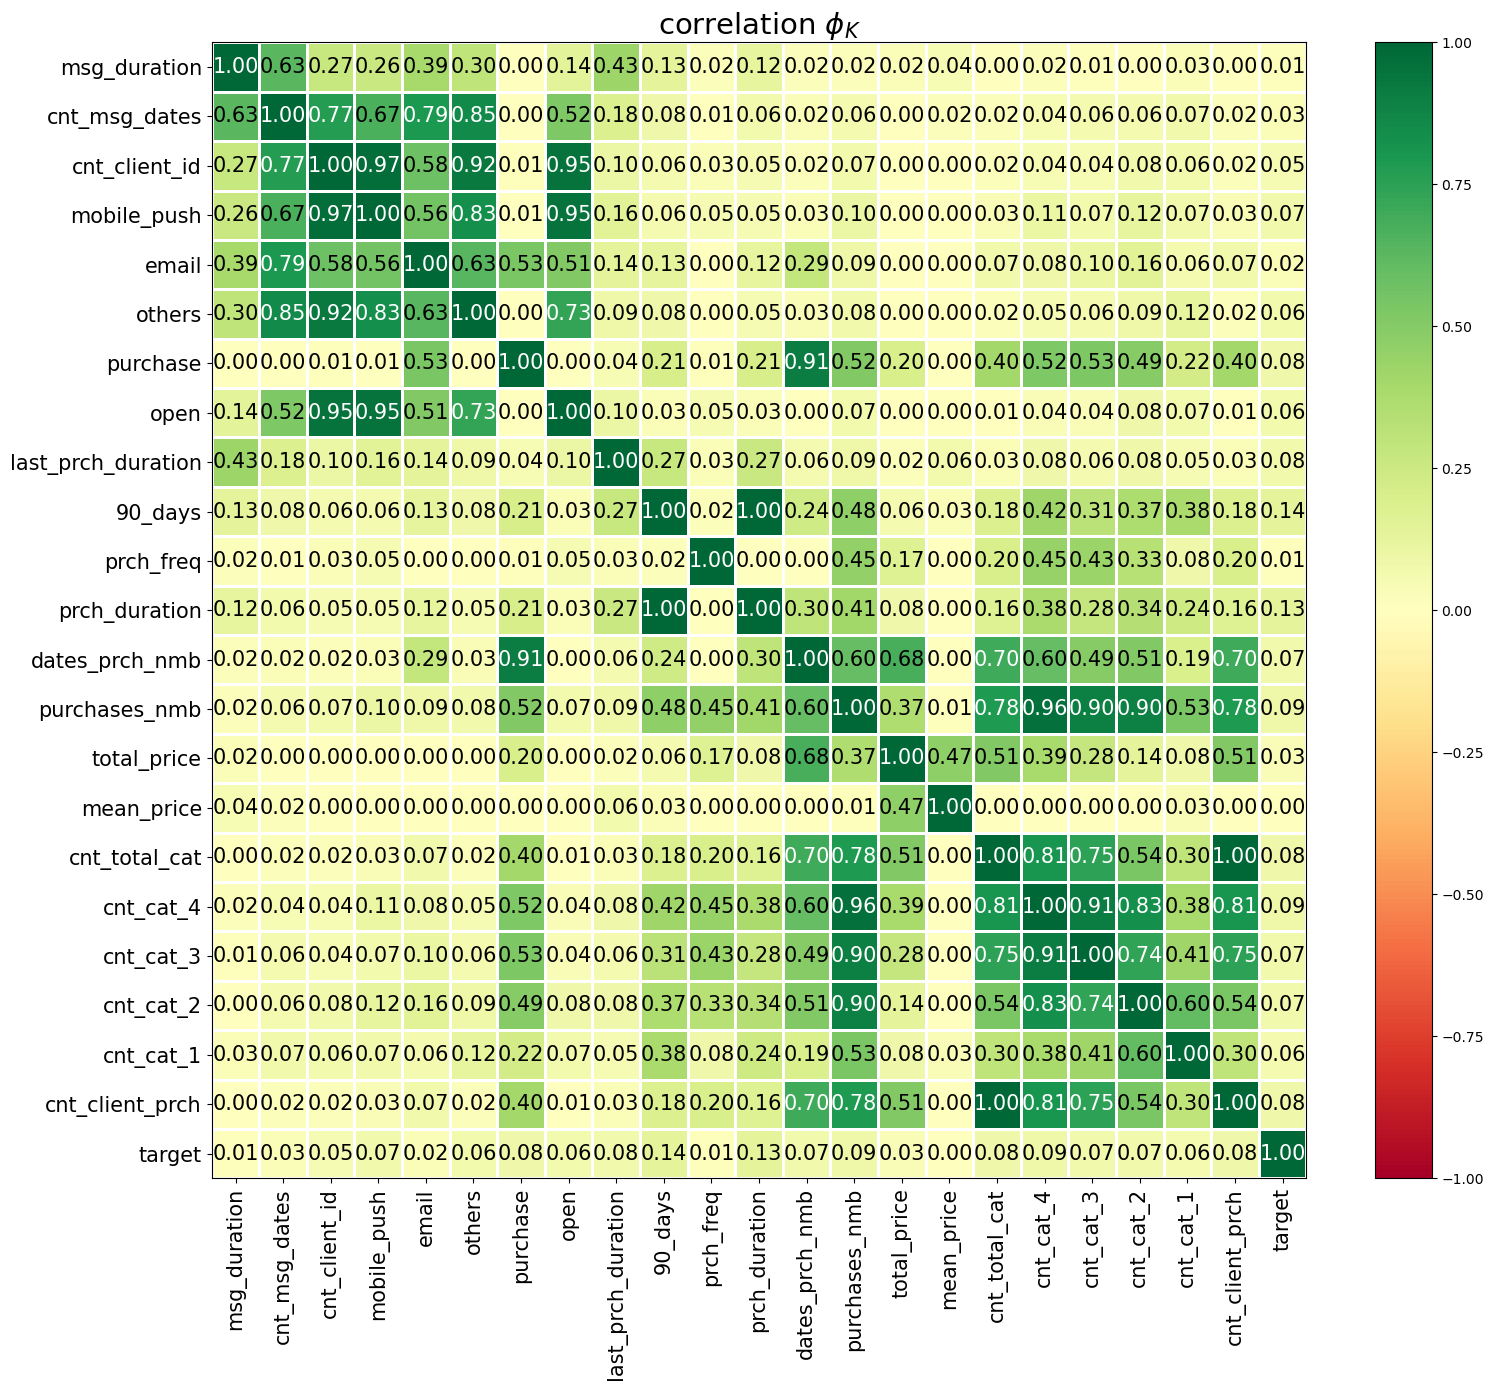

In [63]:
# визуализация тепловой карты коэффициентов корреляции 
plot_correlation_matrix(
    phik_overview.values, 
    x_labels=phik_overview.columns, 
    y_labels=phik_overview.index, 
    title=r"correlation $\phi_K$", 
    fontsize_factor=1.5, 
    figsize=(16, 14)
)

### Уберем гиперколлинеарные признаки

In [64]:
# Создадим новый датафрейм, из которого удалим колонки с датами
assessed_df = final_df[['client_id', 'target', 'cnt_cat_1', 'cnt_cat_2',
       'cnt_cat_3', 'cnt_cat_4', 'cnt_total_cat', 'mean_price', 'total_price',
       'dates_prch_nmb',
       'prch_freq', 'prch_duration', 'last_prch_duration', 'open',
       'purchase', 'others', 'email', 
       'cnt_msg_dates', 'msg_duration']]

In [65]:
assessed_df_phik = assessed_df.drop(['client_id'], axis = 1)
phik_overview = assessed_df_phik.phik_matrix(interval_cols = ['target', 'cnt_cat_1', 'cnt_cat_2',
       'cnt_cat_3', 'cnt_cat_4', 'cnt_total_cat', 'mean_price', 'total_price',
       'dates_prch_nmb',
       'prch_freq', 'prch_duration', 'last_prch_duration', 'open',
       'purchase', 'others', 'email', 
       'cnt_msg_dates', 'msg_duration'])

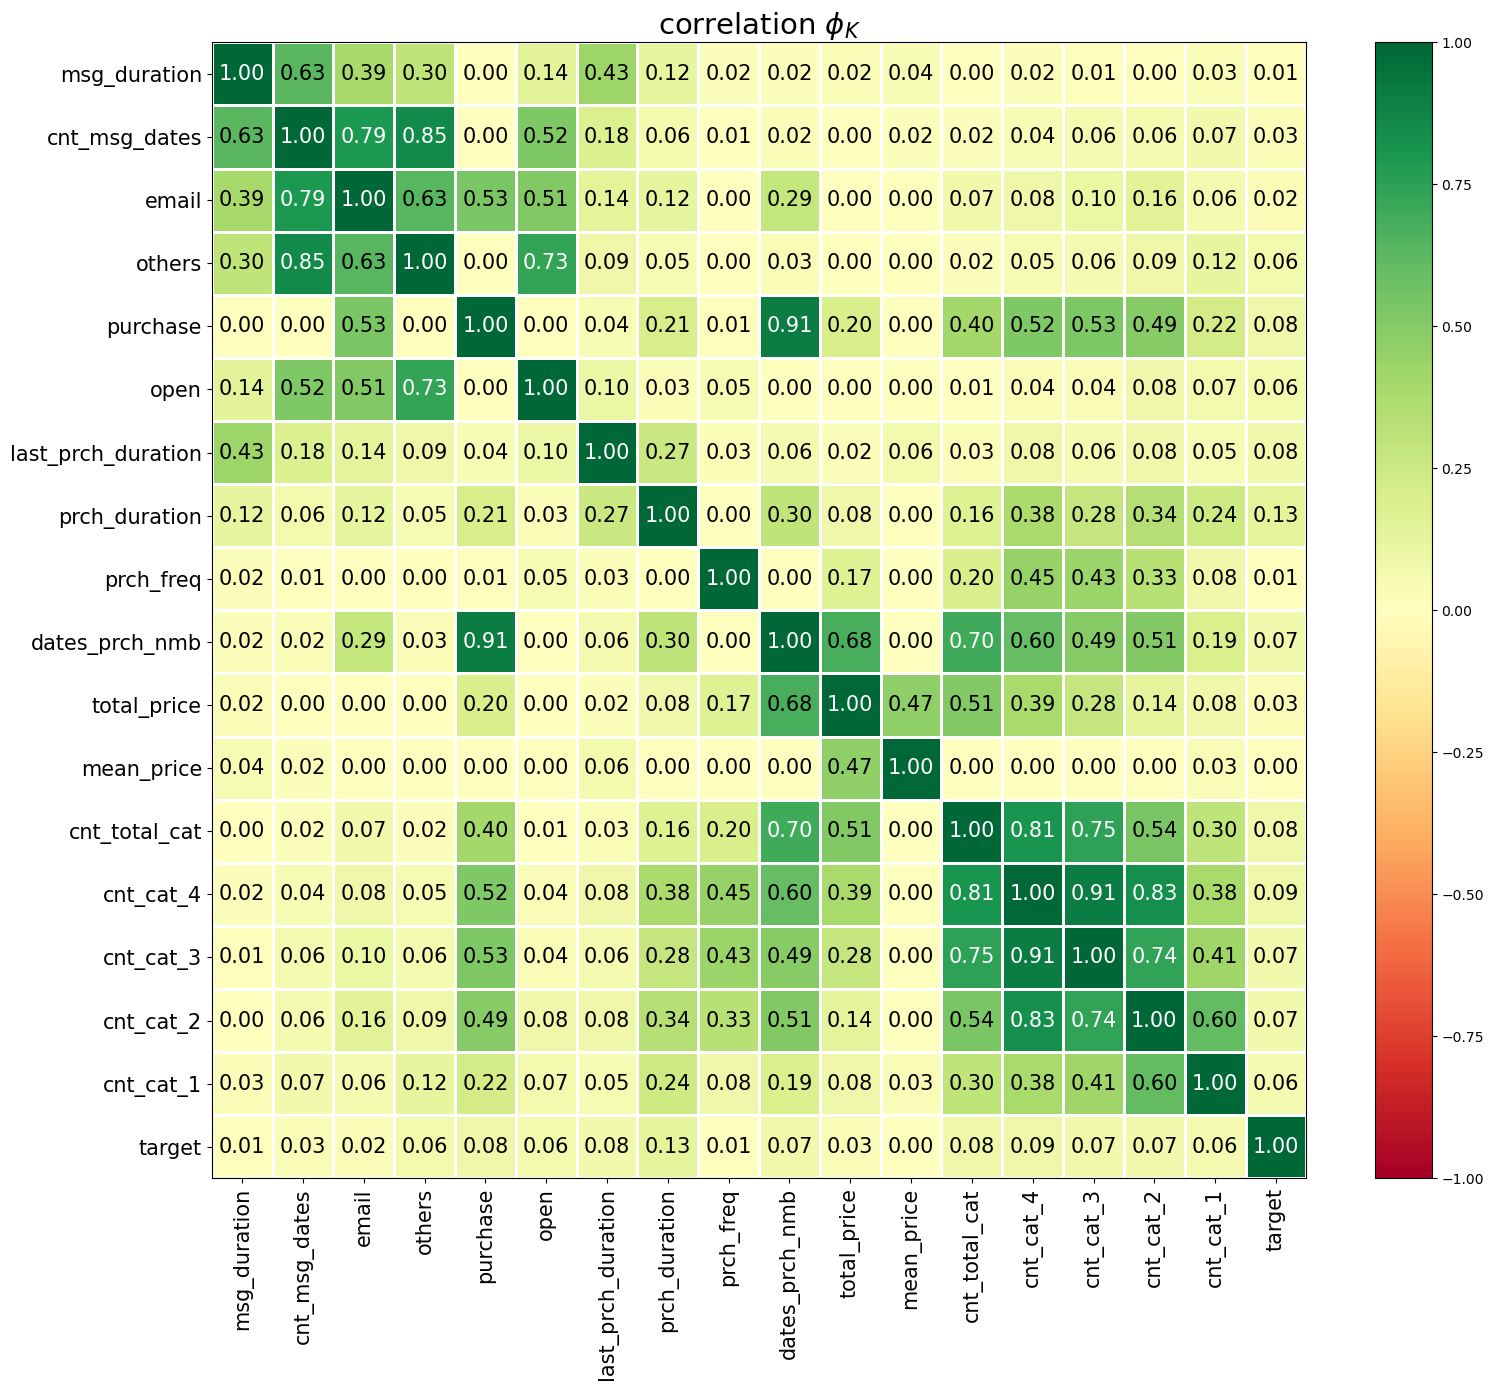

In [66]:
# визуализация тепловой карты коэффициентов корреляции 
plot_correlation_matrix(
    phik_overview.values, 
    x_labels=phik_overview.columns, 
    y_labels=phik_overview.index, 
    title=r"correlation $\phi_K$", 
    fontsize_factor=1.5, 
    figsize=(16, 14)
)

## Подбор модели и поиск гиперпараметров

In [67]:
RANDOM_STATE = 42

In [68]:
# Define your data and split it
X = assessed_df.drop(['client_id', 'target'], axis=1)
y = assessed_df['target']


# Делим данные на тренировочую и тестовую выборки
X_train, X_test, y_train, y_test, client_id_train, client_id_test = train_test_split(
                                            X, y, assessed_df['client_id'], test_size=0.25, 
                                            random_state=RANDOM_STATE, stratify=y)


In [69]:
num_columns =  ['cnt_cat_1', 'cnt_cat_2',
       'cnt_cat_3', 'cnt_cat_4', 'cnt_total_cat', 'mean_price', 'total_price',
       'dates_prch_nmb',
       'prch_freq', 'prch_duration', 'last_prch_duration', 'open',
       'purchase', 'others', 'email', 
       'cnt_msg_dates', 'msg_duration']

In [70]:
# Создадим пайплайн для подготовки признаков из списка num_columns: заполнение пропусков и масштабирование 

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value = 0)), 
    ('scaler', StandardScaler())
    ])

In [71]:
# Создадим ColumnTransformer для подготовки данных

preprocessing = ColumnTransformer(
    [('num', num_pipe, num_columns)],
    remainder='passthrough' )

In [72]:
# Создадим список моделей, которые используем в финальном пайплане
models = {
    'Logistic Regression': LogisticRegression(random_state = RANDOM_STATE, class_weight = 'balanced'),
    'Rundom Forest Classifier': RandomForestClassifier(random_state = RANDOM_STATE, class_weight = 'balanced'),
    'LGBMClassifier': LGBMClassifier(random_state = RANDOM_STATE, force_row_wise = True),
    'XGBoost': XGBClassifier(random_state = RANDOM_STATE, eval_metric = 'logloss')
    }

# Создадим словарь пайплайнов моделей
model_pipelines = {}
for name, model in models.items():
    model_pipelines[name] = Pipeline(steps=[
        ('preprocessor', preprocessing),
        ('model', model)
    ])

In [73]:
# Создадим финальный пайплайн
pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessing),
        ('sampling', SMOTEENN(random_state=RANDOM_STATE)),  # Oversampling minority class
        ('model', model)
    ])

In [74]:
# Создадим словарь для каждой используемой модели с подираемыми для нее гиперпараметрами 
param_grid = {
    'Logistic Regression': {
        'model__C': [0.1, 1.0, 10],
        'model__solver': ['liblinear'],
        'model__max_iter': [200, 300],
        'model__penalty': ['l1', 'l2'],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
    },
    'Rundom Forest Classifier': {
        'model__max_depth': [3, 5, 10],
        'model__min_samples_leaf': [3, 5, 7],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
    },
    'XGBoost': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [1, 3, 5],
        'model__learning_rate': [0.01, 0.1, 0.3],
        'model__alpha': [0, 0.1, 1],  # L1 regularization term (Lasso)
        'model__lambda': [10, 100, 150],  # L2 regularization term (Ridge)
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
    },
    'LGBMClassifier': {
        'model__n_estimators': [150, 200, 300],
        'model__max_depth': [1, 3, 5],
        'model__learning_rate': [0.005, 0.01, 0.1],
        'model__num_leaves': [31, 40],
        'model__force_row_wise': [True],
        'model__verbosity': [-1],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
    }
}


In [75]:
# Определеим гиперпараметры для выбранных моделей
best_classifiers = {}
for name, pipeline in model_pipelines.items():
    search = RandomizedSearchCV(pipeline, param_distributions = param_grid[name],
                          cv=KFold(n_splits=5, shuffle=True, random_state=42),
                          scoring='roc_auc', n_jobs=-1, verbose=1)
    
    search.fit(X_train, y_train)
    
    best_classifiers[name] = search.best_estimator_
    print(f'\nBest parameters for {name}: {search.best_params_}')
    print(f'Best ROC/AUC for {name}: {round(search.best_score_, 3)}')
    


Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best parameters for Logistic Regression: {'preprocessor__num__scaler': RobustScaler(), 'model__solver': 'liblinear', 'model__penalty': 'l2', 'model__max_iter': 300, 'model__C': 1.0}
Best ROC/AUC for Logistic Regression: 0.718
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best parameters for Rundom Forest Classifier: {'preprocessor__num__scaler': StandardScaler(), 'model__min_samples_leaf': 5, 'model__max_depth': 5}
Best ROC/AUC for Rundom Forest Classifier: 0.719
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/naziaignatenko/anaconda3/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



Best parameters for LGBMClassifier: {'preprocessor__num__scaler': MinMaxScaler(), 'model__verbosity': -1, 'model__num_leaves': 31, 'model__n_estimators': 150, 'model__max_depth': 1, 'model__learning_rate': 0.1, 'model__force_row_wise': True}
Best ROC/AUC for LGBMClassifier: 0.729
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best parameters for XGBoost: {'preprocessor__num__scaler': RobustScaler(), 'model__n_estimators': 100, 'model__max_depth': 1, 'model__learning_rate': 0.3, 'model__lambda': 100, 'model__alpha': 0.1}
Best ROC/AUC for XGBoost: 0.728


## Предсказание по  наилучшей найденной модели

In [76]:
# Определим лучшую модель 
best_model_name = max(best_classifiers, key=lambda k: roc_auc_score(
    y_test, best_classifiers[k].predict_proba(X_test)[:, 1]))

# Узнаем имя лучшей модели
best_model = best_classifiers[best_model_name]

# Вычислим предсказания для лучшей модели
y_pred_probs = best_model.predict_proba(X_test)[:, 1]

# Вычислим метрику ROC AUC для лучшей модели
roc_auc = roc_auc_score(y_test, y_pred_probs)
print(f'Best ROC AUC for {best_model_name} on the validation set: {round(roc_auc, 3)}')

Best ROC AUC for LGBMClassifier on the validation set: 0.735


In [77]:
# Создадим таблицу с id клиена и вероятностью совершения покупки
predictions_with_id = pd.DataFrame({
    'client_id': client_id_test,
    'predicted_value': y_pred_probs,
    'target_value': y_test
})

In [78]:
predictions_with_id.head()

,client_id,predicted_value,target_value
23708,1515915625549418656,0.008849,0
39035,1515915625668204460,0.012313,0
20042,1515915625501604546,0.014943,0
27085,1515915625559358442,0.063215,0
15322,1515915625490955940,0.008849,0


In [79]:
predictions_with_id.to_csv('predictions_with_id.txt', sep = '\t', index = False)

## Выводы
1. Загружены и изучены загруженные дата фреймы
2. Созданы новые признаки по каждому датафрему
3. Датафреймы объединены в один по id клиентов
4. Общий датафрейм сильн несбалансирован по целевому признаку
5. Для уравновешивания целевого признака был выбран комбинированный метод SMOTEENN
6. Для подбора модели и гиперпараметров были выбраны разные модели
7. Наилучшей моделью оказалась LGBMClassifier
8. По наилучшей модели была вычислена метрика ROC_AUC и результаты выведены в виде таблицы с расширением txt.

Исходя из анализа данных видно, что активность клиентов неравномерна. Многие клиенты совершают только одну покупку и как правило в первые дни после получения сообщения. Вторичных покупок очень мало, возможно, это связано с особенностью продаваемого товара.